# K-means and XGBoost using SageMaker PySpark

By Ana B. Barcenas

1. [Introduction](#first-bullet)
2. [K-Means](#second-bullet)
3. [XGBoost](#third-bullet)

## 1. Introduction 
<a id="first-bullet"></a>

This notebook will leverage the MNIST dataset (handwritten digits) to perform clustering and multi-class classification through the SageMaker PySpark library..

In particular, we will use Spark to manipulate the dataset followed by KMeans and XGBoost Amazon SageMaker algorithms to cluster and classify the digits.

This notebook is based on the following example notebooks provided by Amazon SageMaker:

> * https://github.com/aws/sagemaker-spark/blob/master/README.md#getting-started-k-means-clustering-on-sagemaker-with-sagemaker-spark-sdk
> * https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-spark/pyspark_mnist/pyspark_mnist_kmeans.ipynb
> * https://github.com/aws/sagemaker-spark/blob/master/sagemaker-pyspark-sdk/README.rst

Import modules.

In [1]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

Create Spark session with the required SageMaker-Spark dependencies.

In [2]:
# get my execution role as defined based on my IAM policy
role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

Set up instance region and load training and test mnist datasets.

In [3]:
region = boto3.Session().region_name
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.com'.format(region))

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



The following are three helper functions to display a digit from the dataset and the last two to display the resulting clusters from KMeans and XGBoost respectively.

In [10]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import string

In [18]:
# Helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayClusters_km(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
def displayClusters_xgb(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("prediction").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.prediction) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()

## 2. K-Means  
<a id="second-bullet"></a>

In [4]:
from sagemaker_pyspark import IAMRole
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator
from sagemaker_pyspark import RandomNamePolicyFactory

In [5]:
# Create K-Means Estimator
kmeans_estimator = KMeansSageMakerEstimator(
    sagemakerRole = IAMRole(role),
    trainingInstanceType = 'ml.m4.xlarge', # Instance type to train K-means on SageMaker
    trainingInstanceCount = 1,
    endpointInstanceType = 'ml.t2.large', # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount = 1,
    namePolicyFactory = RandomNamePolicyFactory("sparksm-1a-")) # All the resources created are prefixed with sparksm-1

In [6]:
# Set parameters for K-Means
kmeans_estimator.setFeatureDim(784)
kmeans_estimator.setK(10)

In [7]:
# Train
initialModel = kmeans_estimator.fit(trainingData)

In [9]:
# Run inference on the test data and show some results
transformedData_Kmeans = initialModel.transform(testData)
transformedData_Kmeans.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...|   1189.67626953125|            8.0|
|  2.0|(784,[94,95,96,97...|  2057.736083984375|            4.0|
|  1.0|(784,[128,129,130...|  1060.170166015625|            7.0|
|  0.0|(784,[124,125,126...|  1583.234619140625|            2.0|
|  4.0|(784,[150,151,159...| 1467.2691650390625|            1.0|
|  1.0|(784,[156,157,158...|  952.8815307617188|            7.0|
|  4.0|(784,[149,150,151...|     1637.416015625|            3.0|
|  9.0|(784,[179,180,181...| 1690.0736083984375|            3.0|
|  5.0|(784,[129,130,131...|   2011.96728515625|            1.0|
|  9.0|(784,[209,210,211...|  1704.381591796875|            3.0|
|  0.0|(784,[123,124,125...|   1602.03271484375|            2.0|
|  6.0|(784,[94,95,96,97...| 1822.2076416015625|            1.0|
|  9.0|(784,[208,209,210.

### Resulting clusters




Cluster A:


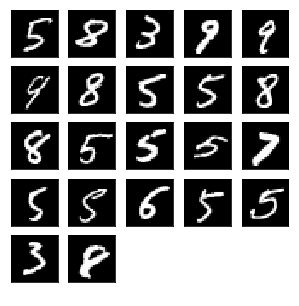




Cluster B:


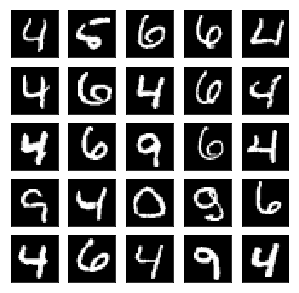




Cluster C:


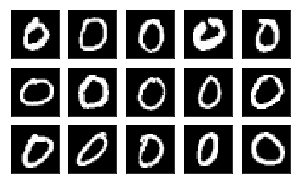




Cluster D:


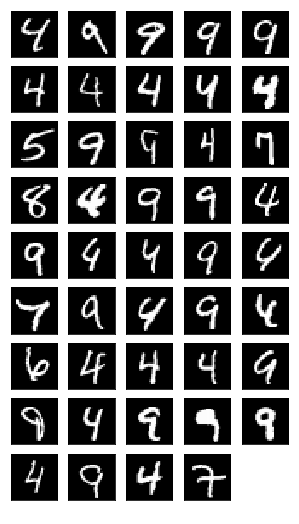




Cluster E:


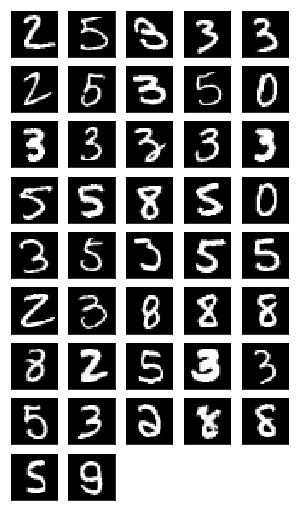




Cluster F:


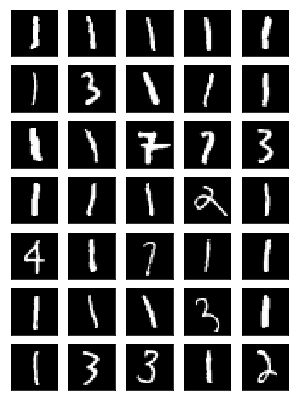




Cluster G:


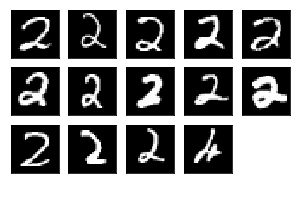




Cluster H:


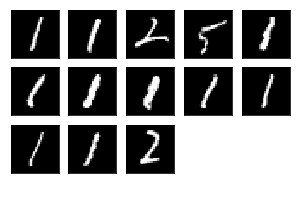




Cluster I:


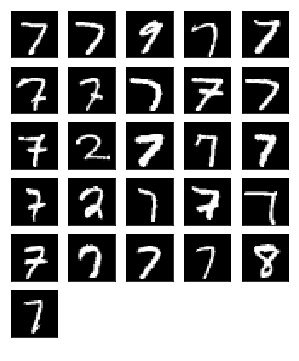




Cluster J:


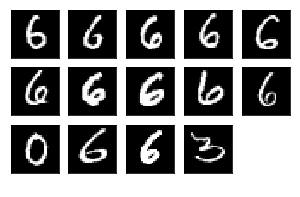

In [12]:
displayClusters_km(transformedData_Kmeans)

## 3. XGBoost 

<a id="third-bullet"></a>

In [13]:
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator

In [15]:
# Create XGBoost Estimator
xgboost_estimator = XGBoostSageMakerEstimator(
    trainingInstanceType="ml.m4.xlarge",
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge",
    endpointInitialInstanceCount=1,
    sagemakerRole=IAMRole(role))

# Set parameters for XGBoost
xgboost_estimator.setObjective('multi:softmax')
xgboost_estimator.setNumRound(25)
xgboost_estimator.setNumClasses(10)

# Train
xgboost_model = xgboost_estimator.fit(trainingData)

In [16]:
# Run inference on the test data and show some results
transformedData_XGBoost = xgboost_model.transform(testData)
transformedData_XGBoost.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  7.0|(784,[202,203,204...|       7.0|
|  2.0|(784,[94,95,96,97...|       2.0|
|  1.0|(784,[128,129,130...|       1.0|
|  0.0|(784,[124,125,126...|       0.0|
|  4.0|(784,[150,151,159...|       4.0|
|  1.0|(784,[156,157,158...|       1.0|
|  4.0|(784,[149,150,151...|       4.0|
|  9.0|(784,[179,180,181...|       9.0|
|  5.0|(784,[129,130,131...|       5.0|
|  9.0|(784,[209,210,211...|       9.0|
|  0.0|(784,[123,124,125...|       0.0|
|  6.0|(784,[94,95,96,97...|       6.0|
|  9.0|(784,[208,209,210...|       9.0|
|  0.0|(784,[152,153,154...|       0.0|
|  1.0|(784,[125,126,127...|       1.0|
|  5.0|(784,[124,125,126...|       5.0|
|  9.0|(784,[179,180,181...|       9.0|
|  7.0|(784,[200,201,202...|       7.0|
|  3.0|(784,[118,119,120...|       3.0|
|  4.0|(784,[158,159,185...|       4.0|
+-----+--------------------+----------+
only showing top 20 rows



### Resulting clusters




Cluster A:


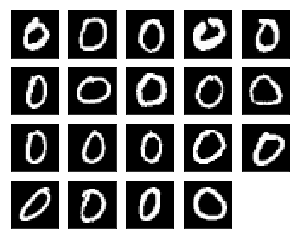




Cluster B:


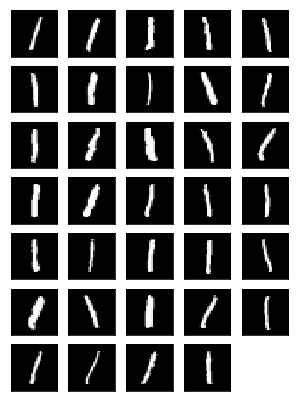




Cluster C:


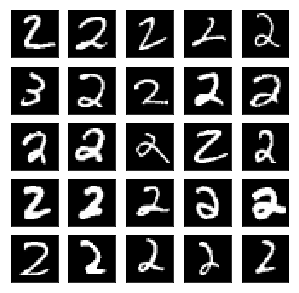




Cluster D:


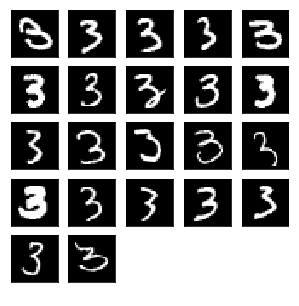




Cluster E:


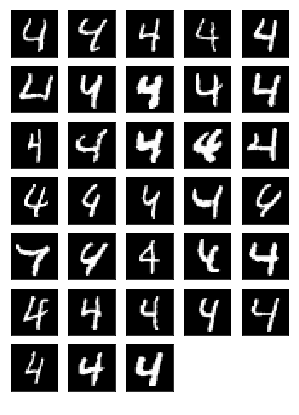




Cluster F:


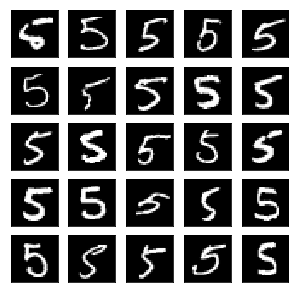




Cluster G:


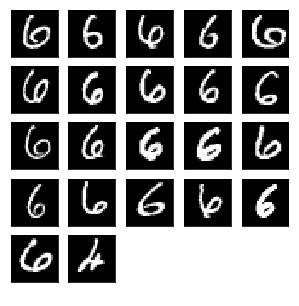




Cluster H:


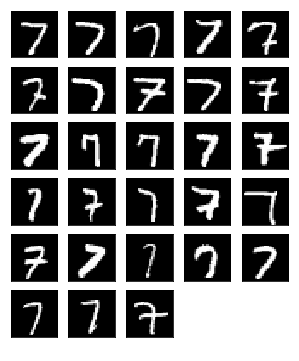




Cluster I:


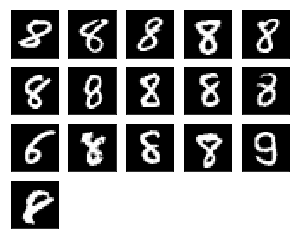




Cluster J:


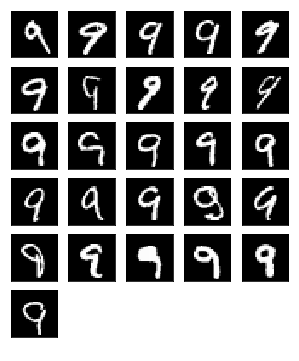

In [19]:
displayClusters_xgb(transformedData_XGBoost)